In [1]:
import os
home = r"C:\Users\rose_\OneDrive\Desktop\DA_Project\DA_Project"   ## use your direcitory (.../data)
home2 = home + '/data'  ## /data/data path can get access to all raw data (tweets, followings)
os.chdir(home)

In [2]:
import tweepy
### Set an API
with open("twitter_key&secret key.txt") as f:
    api_key = f.read().split("\n")
consumer_key = api_key[0]
consumer_secret = api_key[1]
access_token = api_key[2]
access_token_secret = api_key[3]

import tweepy

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Setting wait_on_rate_limit and wait_on_rate_limit_notify to True makes the API object print a message and wait if the rate limit is exceeded
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
import pandas as pd
import numpy as np
valid_data = pd.read_csv("full_data.csv",index_col=0)
valid_data.index = np.arange(len(valid_data))
valid_id = list(valid_data["id"])

In [4]:
tweet_cleaned = pd.read_pickle("tweet_2292.pickle")
emoji_count = pd.read_pickle("emoji_count_2292.pickle")
pred_desc = pd.read_csv("pred_desc.csv",index_col=0)
tweet_cleaned_ml = pd.read_pickle("tweet_cleaned_ml.pickle")
ids_ml = pd.read_pickle("ids_ml.pickle")
tweet_cleaned.update(tweet_cleaned_ml)

<h2> Scores


In [5]:
# Network Scores
def network_evaluation(id1,id_list):
    import networkx as nx  
    import pandas as pd

    network_score = pd.DataFrame(id_list,columns=['id'])
    communicability = list()
    distance = list()
    
    path1 = home2+f"/{id1}"
    os.chdir(path1)
    with open("friends.txt","r",encoding="utf8") as f:
        followings = f.read().split()
        f.close()
    with open("followers.txt","r",encoding="utf8") as f:
        followers = f.read().split()
        f.close()
    friends = list(set(followings) & set(followers))
    oneway_friends = list(set(followings) - set(followers)) 
        
    for id2 in id_list:
        try:
            path2 = home2+f"/{id2}"
            os.chdir(path2)
            with open("friends.txt","r",encoding="utf8") as f:
                followings2 = f.read().split()
                f.close()
            with open("followers.txt","r",encoding="utf8") as f:
                followers2 = f.read().split()
                f.close()
            os.chdir(home)
            friends2 = list(set(followings2) & set(followers2))
            oneway_friends2 = list(set(followings2) - set(followers2))
        except:
            print(id2)
            raise
        
#         edges = list()
#         for i in friends:
#             if i == id2:
#                 continue
#             else:
#                 edges.append(tuple([id1,i]))
#         for i in friends2:   
#             if i == id1:
#                 continue
#             else:
#                 edges.append(tuple([id2,i]))
        
#         G = nx.Graph()
#         G.add_edges_from(edges)
        
        try:
            common_following = len(set(oneway_friends) & set(oneway_friends2))
            following_similarity = common_following/(((len(oneway_friends)+1)*(len(oneway_friends2)+1))**(1/2))
            communicability.append(following_similarity)
        except:
            communicability.append(0)
#         try:
#             distance.append(nx.shortest_path_length(G,id1,id2))    ### can be computationally expensive, use code below instead
#             distance.append()
#         except:
#             distance.append(10000)
        if set(friends) & set(friends2):
            distance.append(2)
        else:
            distance.append(10000)
    network_score["communicability"] = communicability
    network_score["distance"] = distance
        
    return network_score

In [6]:
# LSI

def get_tweeter_similarity(id_,id_list):
    from gensim.similarities.docsim import Similarity
    from gensim import corpora, models, similarities
    from nltk.tokenize import word_tokenize
    from nltk.tokenize import sent_tokenize
    from nltk.probability import FreqDist
    from nltk.corpus import stopwords
    import pandas as pd
    from tqdm import tqdm_notebook
    
    STOPWORDS = stopwords.words()
    
    # construct LSI model
    texts = [[word for word in (tweet_cleaned[i].lower().split())
        if word not in STOPWORDS and word.isalnum()] for i in id_list]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=5)
    
    vec_bow = dictionary.doc2bow(tweet_cleaned[id_].lower().split())
    vec_lsi = lsi[vec_bow]
    index_ = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(enumerate(index_[vec_lsi]))
    similarities = []
    for i in range(len(sims)):
        similarities.append(sims[i][1])
    text_score = pd.DataFrame(id_list,columns=["id"])
    text_score["similarity"] = similarities
    
    return text_score

<h2>Evaluation

In [7]:
def dataset(id_list):
    import pandas as pd
    import numpy as np
    dataset = pd.DataFrame(columns=['id','y','communicability','distance','similarity'])
    for user_id in id_list:
        path1 = home2+f"/{user_id}"
        os.chdir(path1)
        with open("friends.txt","r",encoding="utf8") as f:
            followings = f.read().split()
            f.close()
        followings = [i for i in followings if i in ids_ml]
        data1 = pd.DataFrame(followings,columns=["id"])
        data1["y"] = 1

        # Randomly select data with label 0
        random = np.arange(len(valid_data))
        np.random.shuffle(random)
        followings_check = []
        followings_check.append(user_id)
        followings_check.extend(followings)
        non_followings = list(set(np.array(valid_data["id"][random[:len(followings)]])) - set(followings_check))
        for i in non_followings:
            if os.path.exists(home2+f'/{i}/friends.txt') and os.path.exists(home2+f'/{i}/followers.txt'):
                continue
            else:
                non_followings.remove(i)
        data2 = pd.DataFrame(non_followings,columns=["id"])
        data2["y"] = 0

        data = pd.concat([data1,data2])
        data.index = np.arange(len(data))
        id_list = []
        id_list.extend(followings)
        id_list.extend(non_followings)
        print(f'user {user_id} START')
        print("start network scoring")
        network_score = network_evaluation(user_id,id_list)
        print("start text scoring")
        text_score = get_tweeter_similarity(user_id,id_list)
        score = network_score.merge(text_score,how="right",on="id")
        data = data.merge(score,on="id",how="right")
        dataset = dataset.append(data)
        print(f'user {user_id} DONE')
    
    return dataset

In [8]:
def split_data(data):
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(data, test_size = 0.3)
    x_train = train.iloc[0:,2:]
    y_train = train[['y']]
    x_test = test.iloc[0:,2:]
    y_test = test[['y']]
    return x_train,y_train,x_test,y_test    

In [9]:
def decision_tree(x_train,y_train,x_test,y_test):
    import numpy as np
    from sklearn import tree
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_curve,auc
    import pylab as pl
    %matplotlib inline
    import pydotplus
    
    model = tree.DecisionTreeClassifier(max_depth = 3,criterion='entropy')
    model.fit(x_train,y_train)
    p_train=model.predict(x_train)
    p_test = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(p_train,np.array(y_train)).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(p_test,np.array(y_test)).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    accuracy2 = (tp2+tn2)/(tp2+tn2+fp2+fn2)
    precision = tp/(tp+fp)
    precision2 = tp2/(tp2+fp2)
    tpr = tp/(tp+fn)
    tpr2 = tp2/(tp2+fn2)
    f = precision*tpr/(precision+tpr)*2
    f2 = precision2*tpr2/(precision2+tpr2)*2
    print("\t","training set\ttest set")
    print("Accuracy\t%.2f\t%.2f"%(accuracy,accuracy2),end="\n")
    print("Accuracy\t%.2f\t%.2f"%(accuracy,accuracy2),end="\n")

    (fpr, tpr, thresholds) = roc_curve(y_test,p_test)
    area = auc(fpr,tpr)
    pl.clf() #Clear the current figure
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %.2f"%area)

    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('In sample ROC rocks versus mines')
    pl.legend(loc="lower right")
    pl.show()
    
    feature_names = ["communicability","distance",'similarity']
    dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names)
    graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
    return model,graph
    
# model, graph = decision_tree(x_train,y_train,x_test,y_test)
# from IPython.display import Image
# Image(graph.create_png())

In [10]:
def random_forest(x_train,y_train,x_test,y_test):
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_curve,auc
    import pylab as pl
    import random
    %matplotlib inline
    
    from sklearn.model_selection import GridSearchCV
    parameters = {
         'n_estimators':(5, 10, 30, 50), #the number of trees
         'max_depth':(4,5,6,8,10,15),
         'min_samples_split': (2, 4, 8),
         'min_samples_leaf': (4,8,12,16),
    }
    
    seed = 4
    np.random.seed(seed)
    model_ = GridSearchCV(RandomForestClassifier(),parameters,cv=3,iid=False)
    model_.fit(x_train, np.ravel(y_train))

    model = RandomForestClassifier(
        max_depth = model_.best_params_["max_depth"],
        min_samples_leaf = model_.best_params_["min_samples_leaf"],
        min_samples_split = model_.best_params_["min_samples_split"],
        n_estimators = model_.best_params_["n_estimators"],
        random_state = seed
    )
    model.fit(x_train,np.ravel(y_train))
    p_train=model.predict(x_train)
    p_test = model.predict(x_test)
    
    tn, fp, fn, tp = confusion_matrix(p_train,np.array(y_train)).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(p_test,np.array(y_test)).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    accuracy2 = (tp2+tn2)/(tp2+tn2+fp2+fn2)
    precision = tp/(tp+fp)
    precision2 = tp2/(tp2+fp2)
    tpr = tp/(tp+fn)
    tpr2 = tp2/(tp2+fn2)
    f = precision*tpr/(precision+tpr)*2
    f2 = precision2*tpr2/(precision2+tpr2)*2
    print("\t","training set\ttest set")
    print("Accuracy\t%.2f\t%.2f"%(accuracy,accuracy2),end="\n")
    print("Accuracy\t%.2f\t%.2f"%(accuracy,accuracy2),end="\n")

    (fpr, tpr, thresholds) = roc_curve(y_test,p_test)
    area = auc(fpr,tpr)
    pl.clf() #Clear the current figure
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %.2f"%area)

    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('In sample ROC rocks versus mines')
    pl.legend(loc="lower right")
    pl.show()
    
    return model

# model2 = random_forest(x_train,y_train,x_test,y_test)

In [11]:
def bagging(x_train,y_train,x_test,y_test):
    import numpy as np
    from sklearn.ensemble import BaggingClassifier
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_curve,auc
    import pylab as pl
    %matplotlib inline
    
    from sklearn.model_selection import GridSearchCV
    parameters = {
         'n_estimators':(30, 50),
         'max_samples':(30,40,50),
    }
    
    seed = 2
    np.random.seed(seed)
    model_ = GridSearchCV(BaggingClassifier(),parameters,cv=3,iid=False)
    model_.fit(x_train, np.ravel(y_train))

    model = BaggingClassifier(
        max_samples = model_.best_params_["max_samples"],
        n_estimators = model_.best_params_["n_estimators"],
        random_state = seed
    )
    model.fit(x_train,np.ravel(y_train))
    p_train=model.predict(x_train)
    p_test = model.predict(x_test)
    
    tn, fp, fn, tp = confusion_matrix(p_train,np.array(y_train)).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(p_test,np.array(y_test)).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    accuracy2 = (tp2+tn2)/(tp2+tn2+fp2+fn2)
    precision = tp/(tp+fp)
    precision2 = tp2/(tp2+fp2)
    tpr = tp/(tp+fn)
    tpr2 = tp2/(tp2+fn2)
    f = precision*tpr/(precision+tpr)*2
    f2 = precision2*tpr2/(precision2+tpr2)*2
    print("\t","training set\ttest set")
    print("Accuracy\t%.2f\t%.2f"%(accuracy,accuracy2),end="\n")
    print("Accuracy\t%.2f\t%.2f"%(accuracy,accuracy2),end="\n")

    (fpr, tpr, thresholds) = roc_curve(y_test,p_test)
    area = auc(fpr,tpr)
    pl.clf() #Clear the current figure
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %.2f"%area)

    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('In sample ROC rocks versus mines')
    pl.legend(loc="lower right")
    pl.show()
    
    return model
    
# model3 = bagging(x_train,y_train,x_test,y_test)

In [12]:
def recommendation(score,model):
    recommendation = score
    x = score.iloc[:,1:]
    y_ = model.predict_proba(x)
    prob = [i[1] for i in y_]
    recommendation["prediction"] = prob
    recommendation = recommendation.sort_values(by="prediction",ascending=False)
    return recommendation

<h2> Visual

In [13]:
### Display network
def network_built(id1,id2):
    import networkx as nx     
    import matplotlib.pyplot as plt 
    %matplotlib inline
    plt.style.use('seaborn')
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    plt.style.use('seaborn')
    G = nx.Graph()
    sub_G = nx.Graph()
    
    path1 = home2+f"/{id1}"
    os.chdir(path1)
    with open("friends.txt","r",encoding="utf8") as f:
        followings = f.read().split()
        f.close()
    with open("followers.txt","r",encoding="utf8") as f:
        followers = f.read().split()
        f.close()
    path2 = home2+f"/{id2}"
    os.chdir(path2)
    with open("friends.txt","r",encoding="utf8") as f:
        followings2 = f.read().split()
        f.close()
    with open("followers.txt","r",encoding="utf8") as f:
        followers2 = f.read().split()
        f.close()
    friends = set(followings) & set(followers)
    oneway_friends = list(set(followings) - set(followers)) 
    friends2 = set(followings2) & set(followers2)
    oneway_friends2 = list(set(followings2) - set(followers2)) 
    os.chdir(home)
    
    edges = list()
    for i in oneway_friends:   
        edges.append(tuple([id1,i]))
    for j in oneway_friends2:
        edges.append(tuple([id2,j]))
        
    G.add_edges_from(edges)
    
    sub_edges = list()
    for path in nx.all_simple_paths(G,id1,id2):
        sub_edges.append(tuple([path[0],path[1]]))
        sub_edges.append(tuple([path[1],path[2]]))
    sub_G.add_edges_from(sub_edges)

    fig = plt.figure(figsize=(12,6))
    
    pos = nx.spring_layout(sub_G) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(sub_G,pos,nodelist = [id1,id2],node_color='r',node_size=500,alpha=0.8)
    else_nodes = list(set(sub_G.nodes()) - set([id1,id2]))
    nx.draw_networkx_nodes(sub_G,pos,nodelist=else_nodes,node_color='pink',node_size=100,alpha=0.8)
    
    # edges
    nx.draw_networkx_edges(sub_G,pos,edgelist=sub_G.edges(),width=2,alpha=0.5,edge_color='black')

    node_name = {}
    for node in sub_G.nodes():
        node_name[node] = api.get_user(node).screen_name

    nx.draw_networkx_labels(sub_G,pos,node_name,font_size=12)
    
    # display
    plt.axis('off')
    print("    🧡 You both follow...",end="\n\n")
    plt.show() 
    
    if (friends & friends2):
        common_friends = [api.get_user(i).name for i in list(friends & friends2)]
        common_friends_str = " ".join(common_friends)
        print(f"    🧡 You have common friends: {common_friends}",end="\n\n")
    else:
        print(f"    💙 You don't have common friends YET.",end="\n\n")
    return

In [14]:
# Emoji

# count the emoji for each one
def get_top_emoji(i):
    try:
        return sorted(emoji_count[i], key=lambda item:item[1], reverse=True)[:200]
    except: 
        return 'No emoji'


def get_common_emoji(id1,id2):
    common_emoji=[]
    if get_top_emoji(id1)!='No emoji' and get_top_emoji(id2)!='No emoji':
        emoji1=[list(i)[0] for i in get_top_emoji(id1)]
        emoji2=[list(i)[0] for i in get_top_emoji(id2)]
        common_emoji= list(set(emoji1).intersection(set(emoji2)))
    if common_emoji==[]:
        return 'Sorry, you have no common emoji'
    else:
        return " ".join(common_emoji[:10])

In [15]:
# WordCloud

def Word_cloud(id_):
    import os
    import nltk

    import numpy as np
    import pandas as pd

    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    import PIL.Image as image

    from spacy.lang.en.stop_words import STOP_WORDS

    import re
    import nltk
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    #nltk.download('wordnet') 
    from nltk.stem.wordnet import WordNetLemmatizer
    from sklearn.feature_extraction.text import CountVectorizer
    import re
    
    path1 = home2+f"/{id_}"
    os.chdir(path1)

    with open("description.txt","r",encoding="utf8") as f:
        text1 = f.read()
        f.close()
    with open("tweet.txt","r",encoding="utf8") as f:
        text2 = f.read()
        f.close()

    text = text1 + text2
    
    lem = WordNetLemmatizer()
    stem = PorterStemmer()
    word = "inversely"

    ##Creating a list of stop words and adding custom stopwords
    stop_words = set(stopwords.words("english"))

    ##Creating a list of custom stopwords
    new_words = ['http', 'www', 'com', 'people', 'thing', 'one', 'two', 'three','could','would','actually','never','still','going','maybe','probably','really','person','always','around','though','think','thought','absolutely']
    stop_words = stop_words.union(new_words)

    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Convert to lowercase
    text = text.lower()

    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    ##Convert to list from string
    text = text.split()

    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if (not word in  
            stop_words) and (len(word)>4)] 
    text = " ".join(text)
    fig = plt.figure(figsize=(12,6))
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('seaborn')
    
    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stop_words,
                              max_words=100,
                              max_font_size=50, 
                              random_state=42
                             ).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
#     fig.savefig("word1.png", dpi=900)

In [16]:
def interest_analysis(user_id):
    import json
    import pandas as pd
    import numpy as np
    from gensim.parsing.preprocessing import STOPWORDS
    import string
    from gensim.similarities.docsim import Similarity
    from gensim import corpora, models, similarities
    import re
    df=pd.read_json(home+'/News_Category_Dataset_v2.json',lines=True)
    df['category']=df['category'].map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
    df['text']=df['headline']+'. '+df['short_description']
    df=df[['category','text']]
    df=df.groupby(['category'])['text'].apply(lambda x: ','.join(x)).reset_index()
    all_text=df['text'].tolist()
    texts = [[word for word in document.lower().split()
            if word not in STOPWORDS and word.isalnum()]
            for document in all_text]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=50)
    
    
    file=home2+f'/{user_id}'+'/tweet.txt'
    with open(file,'rb') as f:
        content=f.read()
        content=content.decode('utf-8')
        content=content.replace('|||','')
        content=content.replace('RT','')
        pattern_1=re.compile(r'@[\w]+')
        for word in pattern_1.findall(content):
            content=content.replace(word,'')
        pattern_2=re.compile(r'https://t.co/[\w]+')
        for word in pattern_2.findall(content):
            content=content.replace(word,'') 
        post=[word for word in content.lower().split()
            if word not in STOPWORDS and word.isalnum()]
        vec_bow = dictionary.doc2bow(post)
        vec_lsi = lsi[vec_bow]
        index = similarities.MatrixSimilarity(lsi[corpus])
        sims = index[vec_lsi]
        sims = sorted(enumerate(sims), key=lambda item: -item[1])
        topic_1=df['category'].iloc[sims[0][0]]
        topic_2=df['category'].iloc[sims[1][0]]
        topic_3=df['category'].iloc[sims[2][0]]
        output=f'{topic_1}, {topic_2}, {topic_3}'
    return output

In [17]:
def interest_analysis_pairs(user_id_1,user_id_2):
    import json
    import pandas as pd
    import numpy as np
    from gensim.parsing.preprocessing import STOPWORDS
    import string
    from gensim.similarities.docsim import Similarity
    from gensim import corpora, models, similarities
    import re
    df=pd.read_json(home+'/News_Category_Dataset_v2.json',lines=True)
    df['category']=df['category'].map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
    df['text']=df['headline']+'. '+df['short_description']
    df=df[['category','text']]
    df=df.groupby(['category'])['text'].apply(lambda x: ','.join(x)).reset_index()
    all_text=df['text'].tolist()
    texts = [[word for word in document.lower().split()
            if word not in STOPWORDS and word.isalnum()]
            for document in all_text]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=50)
    
    file_1=home2+f'/{user_id_1}'+'/tweet.txt'
    with open(file_1,'rb') as f:
        content_1=f.read()
        content_1=content_1.decode('utf-8')
        content_1=content_1.replace('|||','')
        content_1=content_1.replace('RT','')
        pattern_1=re.compile(r'@[\w]+')
        for word in pattern_1.findall(content_1):
            content_1=content_1.replace(word,'')
        pattern_2=re.compile(r'https://t.co/[\w]+')
        for word in pattern_2.findall(content_1):
            content_1=content_1.replace(word,'') 
        post_1=[word for word in content_1.lower().split()
            if word not in STOPWORDS and word.isalnum()]
        vec_bow_1 = dictionary.doc2bow(post_1)
        vec_lsi_1 = lsi[vec_bow_1]
        index = similarities.MatrixSimilarity(lsi[corpus])
        sims_1 = index[vec_lsi_1]
        sims_1 = sorted(enumerate(sims_1), key=lambda item: -item[1])
        
    file_2=home2+f'/{user_id_2}'+'/tweet.txt'
    with open(file_2,'rb') as f:
        content_2=f.read()
        content_2=content_2.decode('utf-8')
        content_2=content_2.replace('|||','')
        content_2=content_2.replace('RT','')
        pattern_1=re.compile(r'@[\w]+')
        for word in pattern_1.findall(content_2):
            content_2=content_2.replace(word,'')
        pattern_2=re.compile(r'https://t.co/[\w]+')
        for word in pattern_2.findall(content_2):
            content_2=content_2.replace(word,'') 
        post_2=[word for word in content_2.lower().split()
            if word not in STOPWORDS and word.isalnum()]
        vec_bow_2 = dictionary.doc2bow(post_2)
        vec_lsi_2 = lsi[vec_bow_2]
        index = similarities.MatrixSimilarity(lsi[corpus])
        sims_2 = index[vec_lsi_2]
        sims_2 = sorted(enumerate(sims_2), key=lambda item: -item[1])
    result=[]
    for result_2 in sims_2[:10]:
        for result_1 in sims_1[:10]:
            if result_2[0]==result_1[0]:
                result.append(result_2[0])
    output=[]
    if len(result)<3:
        for i in result:
            item=df['category'].iloc[i]
            output.append(item)
        return f'{" ".join(tuple(output))}'
    else:
        for i in result:
            item=df['category'].iloc[i]
            output.append(item)
        return f'{" ".join(tuple(output[:3]))}'

<h2> F.R.I.E.N.D.S

In [18]:
valid_data[:5]

,id,name,location,followers_count,following_count,favourites_count,statuses_count,listed_count,created_at,address,latitude,longitude,city,region,country,pred
0,992465186362724352,warrior_mhs,"Frisco, TX",154,367,2304,224,0,2018-05-04 18:05:14,"Frisco, TX, USA",33.150674,-96.823612,Frisco,Texas,United States,ENFP
1,1037764508025012225,BchsAll,"Florida, USA",94,325,72,365,0,2018-09-06 18:08:34,"Florida, USA",27.664827,-81.515754,Avon Park,Florida,United States,ISTJ
2,1159308178875670528,HEADPOTUS,"Manhattan, NY",95,4264,2401,3923,0,2019-08-08 03:39:43,"Manhattan, New York, NY, USA",40.783060,-73.971249,Manhattan,New York,United States,INTJ
3,909020687934816256,lacenlyn,United States,1503,3838,27006,18169,3,2017-09-16 11:46:35,United States,37.090240,-95.712891,NaN,NaN,United States,ENTP
4,3742901,tropology,NaN,1692,4500,11764,9045,123,2007-04-07 23:09:31,NaN,NaN,NaN,NaN,NaN,NaN,ENTJ


In [19]:
### The first time constructing dataset

# data = dataset([1037764508025012225,1107619559845126145,2643066562,2770132275])
# data.index = range(len(data))
# data["distance"] = data["distance"].astype(int)
# data["y"] = data["y"].astype(int)
# os.chdir(home)
# data.to_csv('ml_dataset.csv',encoding='utf-8')

In [20]:
os.chdir(home)
data = pd.read_csv('ml_dataset.csv',index_col=0)
data.head()

,id,y,communicability,distance,similarity
0,29974535,1,0.009072,10000,0.637203
1,15209998,1,0.050292,10000,0.192700
2,3437874514,1,0.000000,10000,0.657409
3,3902476168,1,0.030474,2,0.977248
4,3375731260,1,0.041972,2,0.889886


,id,communicability,distance,similarity
y,,,,
0,561043004205047232,0.035690,9979.740628,0.794461
1,120453817658774480,0.051798,8521.065856,0.690851


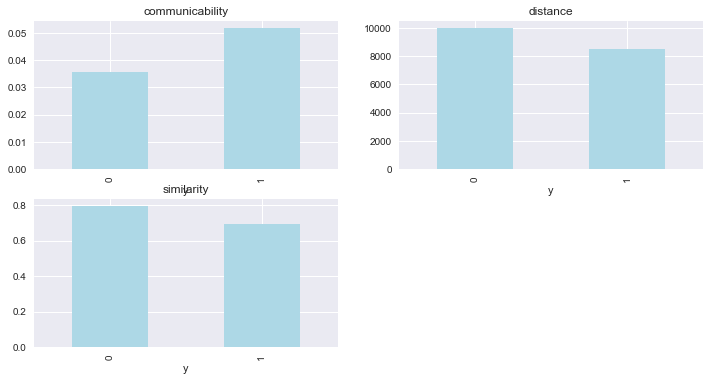

In [21]:
data.index = range(len(data))
data["distance"] = data["distance"].astype(int)
data["y"] = data["y"].astype(int)
group = data.groupby("y").mean()
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')
fig = plt.figure(figsize=(12,6))
for i in range(len(group.columns)):
    if i == 0:
        continue
    else:
        ax = fig.add_subplot(2,2,i)
        plot_data = group.iloc[:,i:i+1]
        plot_data.plot(kind="bar",ax=ax,color='lightblue')
        ax.get_legend().remove()
        plt.title(f"{group.columns[i]}")
group

In [22]:
x_train,y_train,x_test,y_test = split_data(data)

decision_tree
	 training set	test set
Accuracy	0.70	0.67
Accuracy	0.70	0.67


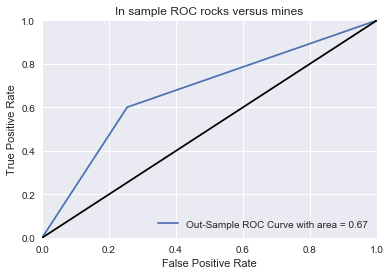

random_forest
	 training set	test set
Accuracy	0.74	0.70
Accuracy	0.74	0.70


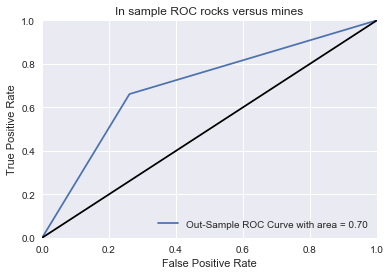

bagging
	 training set	test set
Accuracy	0.72	0.68
Accuracy	0.72	0.68


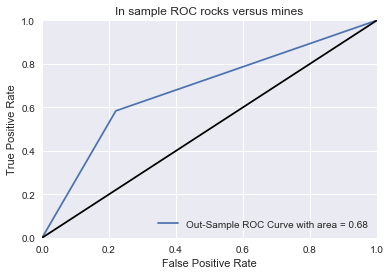

In [23]:
print("decision_tree",end="\n")
model,graph = decision_tree(x_train,y_train,x_test,y_test)
print("random_forest",end="\n")
model2 = random_forest(x_train,y_train,x_test,y_test)
print("bagging",end="\n")
model3 = bagging(x_train,y_train,x_test,y_test)

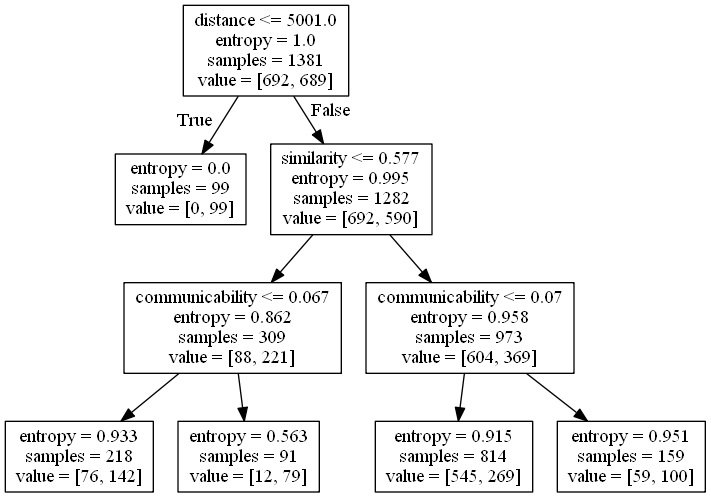

In [24]:
from IPython.display import Image
Image(graph.create_png())

Text(0.5, 0, 'Relative Importance')

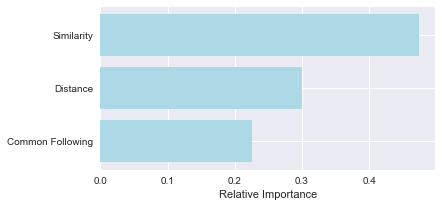

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
importances = model2.feature_importances_
indices = np.argsort(importances)
feature_names= ['Common Following','Distance','Similarity']
plt.figure(figsize=(6,3))
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')

Please enter your twitter account name: miami356
Please type your prefered country:United States
Please type your prefered region:
Please type your prefered personality:ENTJ







							⭐ Your Profile

 📌 country: United States
 📌 region: Florida
 📌 Personality: INTJ
     Have original minds and great drive for implementing their ideas and achieving their goals. Quickly see patterns in external events and develop long-range explanatory perspectives. When committed, organize a job and carry it through. Skeptical and independent, have high standards of competence and performance - for themselves and others.
 📌 Some facts about you: 

    💛 You like to use: 😏 👨‍🚒 🚐 🇵🇭 ☝️ 👍 🇮🇳 👽 🇧🇷 📺

    🧡 You like to talk about: LATINO VOICES, BUSINESS, IMPACT

    💜 You like to say:


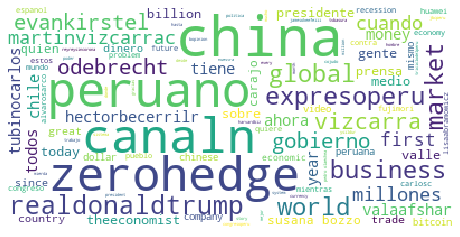






					⭐ Recommendation #1: spdelsol

 📌 country: United States
 📌 region: South Carolina
 📌 Personality: ENTJ
     Have original minds and great drive for implementing their ideas and achieving their goals. Quickly see patterns in external events and develop long-range explanatory perspectives. When committed, organize a job and carry it through. Skeptical and independent, have high standards of competence and performance - for themselves and others.
📌 Some common things about you and spdelsol: 

    🧡 You both follow...



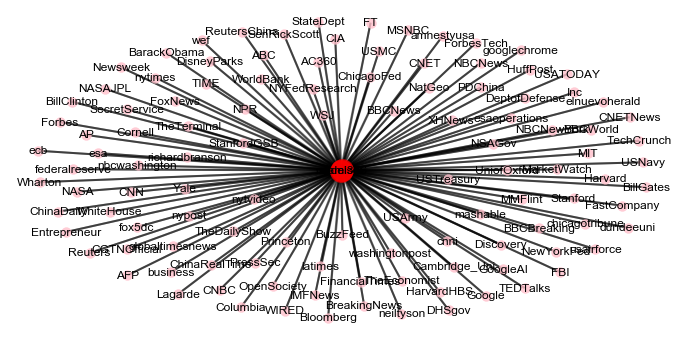

    🧡 You have common friends: ['Evan Kirstel #CES2020']

    💛 You both like to use: ⬇ 😀

    🧡 You both like to talk about: WORLDPOST BUSINESS LATINO VOICES

    💜 He/She likes to say:


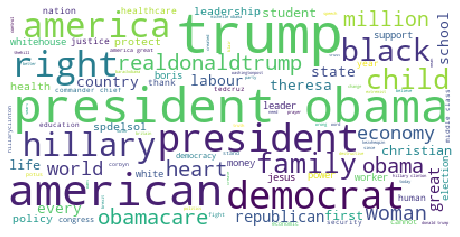






					⭐ Recommendation #2: PoliticalReyna

 📌 country: United States
 📌 region: Texas
 📌 Personality: ENTJ
     Have original minds and great drive for implementing their ideas and achieving their goals. Quickly see patterns in external events and develop long-range explanatory perspectives. When committed, organize a job and carry it through. Skeptical and independent, have high standards of competence and performance - for themselves and others.
📌 Some common things about you and PoliticalReyna: 

    🧡 You both follow...



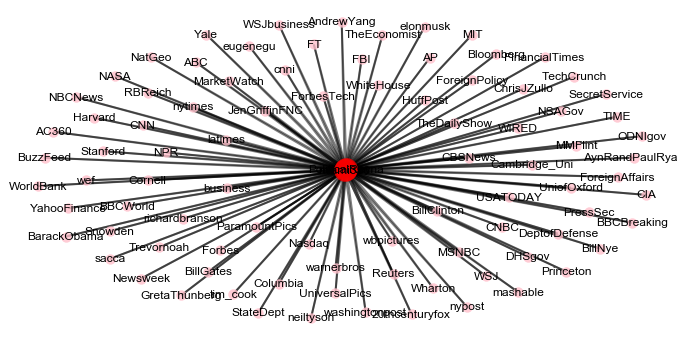

    💙 You don't have common friends YET.

    💛 You both like to use: 🤣 😉 🧐 👋 😂 📺 😅 👏 🇺🇸

    🧡 You both like to talk about: WORLDPOST LATINO VOICES IMPACT

    💜 He/She likes to say:


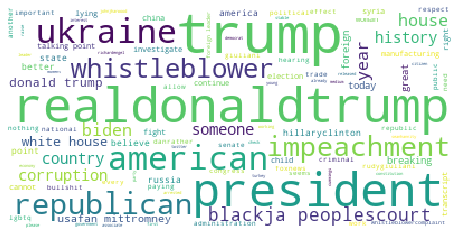






					⭐ Recommendation #3: cxmckenna

 📌 country: United States
 📌 region: Georgia
 📌 Personality: ENTJ
     Have original minds and great drive for implementing their ideas and achieving their goals. Quickly see patterns in external events and develop long-range explanatory perspectives. When committed, organize a job and carry it through. Skeptical and independent, have high standards of competence and performance - for themselves and others.
📌 Some common things about you and cxmckenna: 

    🧡 You both follow...



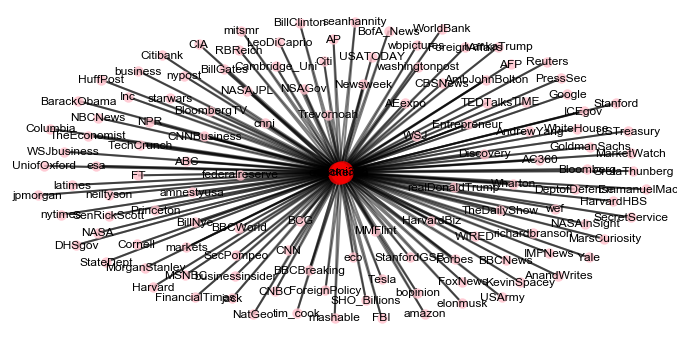

    💙 You don't have common friends YET.

    💛 You both like to use: 🇪🇸 🇦🇺 🤣 😀 🤪 🇨🇭 👇🏼 😳 💰 😂

    🧡 You both like to talk about: LATINO VOICES WORLDPOST ENTERTAINMENT

    💜 He/She likes to say:


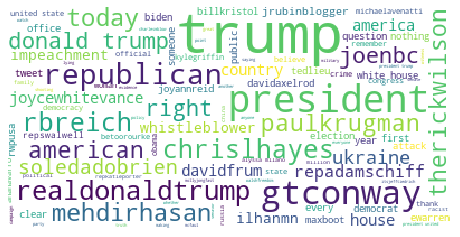

In [26]:
def friends(user,prefered_country,prefered_region,prefered_personality):
    id1 = api.get_user(user).id
    pool = valid_data
    if prefered_personality:
        pool = pool[pool['pred'] == prefered_personality]
    if prefered_country:
        pool = pool[pool['country'] == prefered_country]
    if prefered_region:
        pool = pool[pool['region'] == prefered_region]
    id_list = pool[pool["id"]!=id1]["id"]
    
    # Scores
    network_score = network_evaluation(id1,id_list)
    text_score = get_tweeter_similarity(id1,id_list)
    score = network_score.merge(text_score,how="right",on="id")
    
    # Use Deicison Tree to recommend
    recommend = recommendation(score,model2)
    id_recommend = recommend["id"][:3]
    
    # Display
    personality = valid_data[valid_data['id'] == id1]['pred'].iloc[0]
    desc = pred_desc[pred_desc['pred'] == personality]['desc'].iloc[0]
    print("\t\t\t\t\t\t\t⭐ Your Profile",end="\n\n")
    print(f" 📌 country: {valid_data[valid_data['id']==id1]['country'].iloc[0]}",end="\n")
    print(f" 📌 region: {valid_data[valid_data['id']==id1]['region'].iloc[0]}",end="\n")
    print(f" 📌 Personality: {personality}",end="\n")
    print(f"     {desc}",end='\n')
    print(f" 📌 Some facts about you: ",end="\n\n")
    print(f"    💛 You like to use: {get_common_emoji(id1,id1)}",end="\n\n")
    print(f"    🧡 You like to talk about: {interest_analysis(id1)}",end='\n\n') 
    print(f"    💜 You like to say:",end='\n') 
    Word_cloud(id1)
    print("\n\n\n\n")
    n = 1
    for i in id_recommend:
        personality2 = pool[pool['id'] == i]['pred'].iloc[0]
        desc2 = pred_desc[pred_desc['pred'] == personality]['desc'].iloc[0]
        try:
            print(f"\t\t\t\t\t⭐ Recommendation #{n}: {api.get_user(i).screen_name}",end="\n\n")
            print(f" 📌 country: {pool[pool['id']==i]['country'].iloc[0]}",end="\n")
            print(f" 📌 region: {pool[pool['id']==i]['region'].iloc[0]}",end="\n")
            print(f" 📌 Personality: {personality2}",end="\n")
            print(f"     {desc2}",end='\n')
            print(f"📌 Some common things about you and {api.get_user(i).screen_name}: ",end="\n\n")
            network_built(id1,i)
            print(f"    💛 You both like to use: {get_common_emoji(id1,i)}",end="\n\n")
            print(f"    🧡 You both like to talk about: {interest_analysis_pairs(id1,i)}",end='\n\n') 
            print(f"    💜 He/She likes to say:",end='\n')  
            Word_cloud(i)
            print("\n\n\n\n")
            n += 1
        except:
            continue
    return

user = input("Please enter your twitter account name:")
prefered_country = input("Please type your prefered country:")
prefered_region = input("Please type your prefered region:")
if not prefered_country:
    prefered_country = None
if not prefered_region:
    prefered_region = None
prefered_personality = input("Please type your prefered personality:")
if not prefered_personality:
    prefered_personality = None
print("\n\n\n\n\n\n")
friends(user,prefered_country,prefered_region,prefered_personality)